# Intro to Pyro

This notebook contains a basic introduction to Bayesian modelling and inference in Pyro adapted from: http://pyro.ai/examples/index.html and https://bookdown.org/robertness/causalml/docs/tutorial-on-deep-probabilitic-modeling-with-pyro.html#introduction-to-pyro, written by Ben Moseley.

<img src="https://pyro.ai/img/pyro_logo.png" width="100" align="left"/>

# What is a probabilistic programming language?

“A probabilistic programming language (PPL) is a programming language designed to describe **probabilistic models** and then perform **inference** in those models. PPLs are closely related to graphical models and Bayesian networks but are more expressive and flexible. Probabilistic programming represents an attempt to”Unify general purpose programming" with probabilistic modeling."

-Wikipedia: https://en.wikipedia.org/wiki/Probabilistic_programming

A PPL is a domain-specific programming language for that lets you write a data generating process as a program. Similar to causal Bayesian networks, you can write your program in a way that orders the steps of its execution according to cause and effect.

# Pyro

Pyro is a universal probabilistic programming language (PPL) written in Python and supported by PyTorch on the backend. Pyro enables flexible and expressive deep probabilistic modeling, unifying the best of modern deep learning and Bayesian modeling.

What this really means: Pyro provides a vast array of modelling and inference abilities, which are super-charged by PyTorch's automatic differentiation and GPU computing.

In [101]:
import torch
import pyro
pyro.set_rng_seed(101)

# Bayesian modelling in Pyro

In essence, Bayesian inference in PPL (Pyro included) consists of two simple steps:

1) Define a probabilistic **model**.

2) Carry out **inference** on this model.

We will show you how to carry out both of these steps in Pyro.

# 1) Defining a model (aka, stochastic function)

In Pyro, a model is defined using a **"stochastic function"**.

A stochastic function is an arbitrary Python callable (function or method) that combines two ingredients:

- Deterministic Python code
- Primitive stochastic functions that call a random number generator.

## Primitive stochastic functions

These are basic elements which allow us to introduce stochasticity into our model, and essentially allow us to define different **distributions** in our model. The code below defines a normal distribution and samples from it:

In [102]:
loc = 0.   # mean zero
scale = 1. # unit variance
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
x = normal.rsample() # draw a sample from N(0,1)
print("sample: ", x, type(x))# returns a pytorch tensor

sample:  tensor(-1.3905) <class 'torch.Tensor'>


Pyro provides a thin wrapper around `torch.distributions`, to simplify the process of defining and sampling from distributions:

In [106]:
import pyro.distributions as dist

x = pyro.sample("my_sample", pyro.distributions.Normal(loc, scale))
print(x, type(x))

tensor(-1.7534) <class 'torch.Tensor'>


Just like a direct call to `torch.distributions.Normal().rsample()`, `pyro.sample` returns a sample from the unit normal distribution. The crucial difference is that this sample is **named**. Pyro’s backend uses these names to uniquely identify sample statements and change their behavior at runtime depending on how the enclosing stochastic function is being used. This is how Pyro can implement the various manipulations that underlie inference algorithms.

## A simple model

Now we are ready to write our first probabilistic model! All probabilistic programs are built up by composing primitive stochastic functions and deterministic code. Let's write a simple `weather` model:

In [107]:
def weather():
    "Our Pyro model of the weather"
    "Modified for celsius and more accurate english weather"
    
    # define cloudy as a random variable with a Bernoulli prior distribution
    cloudy = pyro.sample('cloudy', dist.Bernoulli(0.75))
    # define temperature as a random variable, through its conditional distribution with cloudy
    weather_type = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    loc = {'cloudy': 12.5, 'sunny': 17.5}[weather_type]
    scale = {'cloudy': 5.0, 'sunny': 7.5}[weather_type]
    temperature = pyro.sample('temperature', dist.Normal(loc, scale))
    
    return weather_type, temperature

for _ in range(3):
    weather_type, temperature = weather()
    print("The weather is: %s and the temperature is: %.2f C"%(weather_type, temperature.item()))

The weather is: cloudy and the temperature is: 15.52 C
The weather is: sunny and the temperature is: 26.27 C
The weather is: cloudy and the temperature is: 17.96 C


We note a few important things about our model here:
- We defined two random variables in our model: the first is `cloudy` defined through its prior distribution (i.e. $P(cloudy)$), and the second is `temperature`, which depends on `cloudy` and is defined through its conditional distribution with `cloudy` (i.e. $P(temperature | cloudy)$). (Note the similarity to causal Bayesian networks!).
- According to our model, the weather is cloudy 30% of the time, and sunny the rest. On sunny days, the average temperature is higher than on cloudy days.
- We are able to add complex **conditional logic** to the model: the mean and standard deviation of `temperature` depends discontinuously on the value of `cloudy`.
- The model is evaluated **dynamically**: samples (PyTorch tensors) from the model are drawn during the execution of the function (i.e. the model is not statically defined before it is sampled), just like in normal PyTorch code.
- Because we use `pyro.sample` and `pyro.distributions`, `weather` defines a probabilistic model that we can carry out inference over (see later).

We can build complex models by modularizing and reusing such functions, using them as programmers use functions:

In [108]:
def ice_cream_sales():
    "Another Pyro model"
    
    # define ice_cream as a random variable, through its conditional distribution with cloudy and temperature
    weather_type, temperature = weather()
    expected_sales = 200. if weather_type == 'sunny' and temperature > 25.0 else 50.
    ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.0))# number of ice cream sales
    return weather_type, ice_cream

print(ice_cream_sales())

('cloudy', tensor(52.1530))


This kind of modularity, familiar to any programmer, is obviously very powerful. But is it powerful enough to encompass all the different kinds of models we’d like to express?

It turns out that because Pyro is embedded in Python, stochastic functions can contain arbitrarily complex deterministic Python and randomness can freely affect control flow. For example, we can even construct recursive functions that terminate their recursion nondeterministically, provided we take care to pass `pyro.sample` unique sample names whenever it’s called. Check out: http://pyro.ai/examples/intro_part_i.html for more examples of this.

> **Task 1**: draw 1,000 samples of `ice_cream` from the `ice_cream_sales` model, and plot separate histograms of the expected number of ice cream sales for sunny and cloudy days respectively.

(array([ 1.,  0.,  2.,  5.,  8., 18., 28., 31., 42., 53., 72., 83., 74.,
        73., 70., 52., 49., 39., 20., 25.,  4.,  4.,  6.,  1.,  1.]),
 array([16.3160553 , 18.97271362, 21.62937195, 24.28603027, 26.9426886 ,
        29.59934692, 32.25600525, 34.91266357, 37.5693219 , 40.22598022,
        42.88263855, 45.53929688, 48.1959552 , 50.85261353, 53.50927185,
        56.16593018, 58.8225885 , 61.47924683, 64.13590515, 66.79256348,
        69.4492218 , 72.10588013, 74.76253845, 77.41919678, 80.0758551 ,
        82.73251343]),
 <BarContainer object of 25 artists>)

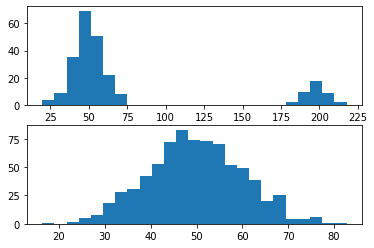

In [109]:
import matplotlib.pyplot as plt

## TODO: write some code here
num_samples=1000
samples = [ice_cream_sales() for _ in range(num_samples)]
sunny_data = [t.item() for w, t in samples if w == 'sunny']
cloudy_data = [t.item() for w, t in samples if w != 'sunny']
fig, axs = plt.subplots(2)
axs[0].hist(sunny_data, bins=25)
axs[1].hist(cloudy_data, bins=25)

# 2) Inference

As we discussed earlier, the reason we use PPLs is because they can easily go backwards and reason about cause given the observed effect, i.e. they can carry out **inference**. There are myriad of inference algorithms available in Pyro.

## An even simpler model

To demonstrate inference in Pyro, we'll use an even simpler model. Consider trying to estimate the weight, $w$, of some object (In probabilistic language, the weight here is a latent, or **unobserved random variable** we would like to infer).

Consider also that we also have an unreliable measuring scale, which measures the weight of the object as $m$.

Then, let's assume that the probability of a measurement given the weight of the object is given by:

$
P(m | w) = \mathcal{N}(m; \mu=w, \sigma^{2}=0.75)
$

Also consider the situation where we know the prior distribution of the object's weight (for example, we weighed it in our hand before placing it on the scale):

$
P(w) = \mathcal{N}(w; \mu=10, \sigma^{2}=1)
$

In Pyro, we can write this model as follows:

In [110]:
def scale():
    weight = pyro.sample("weight", dist.Normal(10, 1.0))
    measurement = pyro.sample("measurement", dist.Normal(weight, 0.75))
    return measurement
print(scale())

tensor(10.0213)


Now, given the value of the measurement $m$ (i.e. an **observation**), we want to infer the **posterior distribution** of the weight of the object, i.e.

$P(w | m)$

Which, by Bayes rule, is given by

$P(w | m) = {P(m | w) P(w) \over P(m)}
$

## Adding observed data (aka, conditioning) in Pyro

To obtain the posterior distribution in Pyro, we first need a way to feed in **observations** (i.e. the scale measurement value) to our model.

In Pyro this is known as "conditioning", and is done using the following code:

In [111]:
conditioned_scale = pyro.condition(scale, data={"measurement": torch.tensor(14.)})

`pyro.condition` is a higher-order function that takes a model and a dictionary of observations and returns a new model that has the same input and output signatures but always uses the given values at observed `sample` statements.

Another, alternative way which is sometimes easier is to pass observations directly to individual `pyro.sample` statements, using the optional `obs` keyword:

In [112]:
def scale_obs():  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", dist.Normal(10, 1.0))
    measurement = pyro.sample("measurement", dist.Normal(weight, 0.75), obs=14.)
    return measurement

## Inference using MCMC

Now, all we need to do is use an inference algorithm to estimate the posterior distribution of the unobserved random variables in our model (in this case, the weight of the object), given the observed data.

There are many different ways to do this in Pyro (see here: http://docs.pyro.ai/en/stable/inference.html ); one is to use Hamiltonian Monte Carlo sampling to draw samples from the posterior: (http://docs.pyro.ai/en/stable/mcmc.html ).

In [113]:
from pyro.infer.mcmc import MCMC
from pyro.infer.mcmc.nuts import HMC

hmc_kernel = HMC(conditioned_scale, step_size=0.9, num_steps=4)# defines a HMC kernel
sampler = MCMC(hmc_kernel, # uses MCMC with HMC kernel
               num_samples=1000, # generates 1000 samples
               warmup_steps=50)# burn-in of 50 steps
sampler.run()
sampler.summary()

Sample: 100%|██████████| 1050/1050 [00:07, 140.14it/s, step size=2.98e-01, acc. prob=0.965]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    weight     12.56      0.61     12.57     11.60     13.56   2694.30      1.00

Number of divergences: 0


We can use `sampler.get_samples()` to obtain the resulting posterior samples.

> **Task 2**: plot the samples from the posterior distribution as a histogram below:

<class 'torch.Tensor'>


(array([  1.,   2.,   6.,   5.,  11.,  16.,  29.,  27.,  69.,  78.,  81.,
        103.,  88., 109.,  96.,  86.,  59.,  60.,  31.,  16.,  11.,   9.,
          5.,   1.,   1.]),
 array([10.5315218 , 10.69085304, 10.85018429, 11.00951553, 11.16884678,
        11.32817802, 11.48750927, 11.64684052, 11.80617176, 11.96550301,
        12.12483425, 12.2841655 , 12.44349674, 12.60282799, 12.76215923,
        12.92149048, 13.08082172, 13.24015297, 13.39948421, 13.55881546,
        13.71814671, 13.87747795, 14.0368092 , 14.19614044, 14.35547169,
        14.51480293]),
 <BarContainer object of 25 artists>)

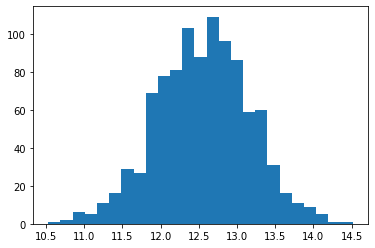

In [114]:
posterior = sampler.get_samples()
print(type(posterior['weight']))# note, this is just a python dictionary
# print([t.item() for t in posterior['weight']])
plt.hist([t.item() for t in posterior['weight']], bins=25)

## Inference using variational inference

Instead of using MCMC to draw samples from the posterior, another option is to use **variational inference** to fit an (approximate) distribution $Q$ to the true posterior distribution of the unobserved variables, given the observed variable values (http://docs.pyro.ai/en/stable/inference_algos.html ).

First, we need to define a flexible approximate distribution $Q$, or **guide function** as it is called in Pyro, to fit to the posterior:

In [115]:
def guide():
    "Defines an approximate distribution Q we will fit to the posterior"
    
    # here, we define Q as a normal distribution, with flexible (trainable) parameters a and b
    a = pyro.param("a", torch.tensor(1.))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

Importantly, guide functions must satisfy these two criteria to be valid approximations for a particular model:

1. all unobserved (i.e., not conditioned) sample statements that appear in the model appear in the guide. Concretely, if the model contains `pyro.sample("z_1", ...)`, where `"z_1"` is unobserved, then the guide must also contain `pyro.sample("z_1", ...)`.
2. the guide has the same input signature as the model (i.e., takes the same arguments).

There are a few things to note here:
- Here, we define Q to be a normal distribution, with its mean and standard deviation as trainable parameters.
- We use `pyro.param` to define the trainable parameters in Q. Pyro `Parameters` are a thin wrapper over `torch.Tensor`, and, (similar to `pyro.sample`), `pyro.param` crucially assigns a name to the parameter, to allow the underlying inference algorithm to keep track of it.
- Also note we had to apply `torch.abs` to parameter `b` because the standard deviation of a normal distribution has to be positive; similar restrictions also apply to parameters of many other distributions.
- Pyro `Parameters` automatically start tracking the gradient of their underlying Torch tensor, which will allow Pyro to use automatic differentiation and gradient descent on loss functions used for inference to update them:

In [116]:
a = pyro.param("new_param", torch.tensor(1.))
print(a, a.requires_grad)

tensor(1., requires_grad=True) True


Although the precise meaning of the guide is different across different inference algorithms, the guide function should generally be chosen so that, in principle, it is *flexible enough to closely approximate the posterior distribution over all unobserved variables in the model*. It turns out, for the `scale` model above, the posterior can be analytically derived as a Normal distribution, so we are good in this case (in general it is usually intractable).

> (Optional) **Extension Task 1**: show that for the `scale` model, the posterior distribution is a Normal distribution and derive its mean and variance.

In [117]:
import numpy as np
print("True analytical posterior parameters:")
print("loc = ", (0.75**2 * 10 + 14.) / (1 + 0.75**2))
print("scale = ", np.sqrt(0.75**2/(1 + 0.75**2)))

True analytical posterior parameters:
loc =  12.56
scale =  0.6


### More on pyro.param

`pyro.param` is actually a frontend for Pyro’s key-value parameter store (see the documentation for more detail). Importantly, the first time `pyro.param` is called with a particular name, it stores its argument in the parameter store and then returns that value. After that, when it is called with that name, it returns the value from the parameter store regardless of any other arguments.

You can call `pyro.clear_param_store()` to clear the parameter store before initialising a parameter again.

In [118]:
a = pyro.param("new_param", torch.tensor(10.))# value of 10. is ignored (!)
print(a, a.requires_grad)

pyro.clear_param_store()
a = pyro.param("new_param", torch.tensor(10.))
print(a, a.requires_grad)

tensor(1., requires_grad=True) True
tensor(10., requires_grad=True) True


## Training Q

Now, we are ready to fit the approximate posterior distribution to the true posterior distribution. To do this, we will maximise the Evidence Lower Bound, or ELBO, using stochastic gradient descent. This essentially minimises the Kullback–Leibler divergence between the true posterior and Q.

In the code below, Pyro computes Monte Carlo estimates of the ELBO, and the guide parameters are updated using SGD. For more details, see: http://pyro.ai/examples/svi_part_i.html

In [119]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import SGD
from tqdm import tqdm

pyro.clear_param_store()
svi = SVI(model=conditioned_scale,
          guide=guide,
          optim=SGD({"lr": 0.001, "momentum":0.1}),
          loss=Trace_ELBO(num_particles=1))# num_particles is the number of MC samples used to estimate ELBO

losses, a,b  = [], [], []
num_steps = 2500
for i in tqdm(range(num_steps)):
    losses.append(svi.step())
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

print('a = ', a[-1])
print('b = ', b[-1])


100%|██████████| 2500/2500 [00:02<00:00, 999.58it/s] 

a =  12.539673805236816
b =  0.6210799813270569


> **Task 3**: plot the values of the ELBO, `a` and `b` as a function of training step.

> **Task 4**: plot the posterior distribution by drawing samples from Q. Compare this to the posterior samples estimated from HMC above.

Note that optimization will update the values of the guide parameters in the parameter store, so that once we find good parameter values, we can use samples from the guide as posterior samples for downstream tasks.

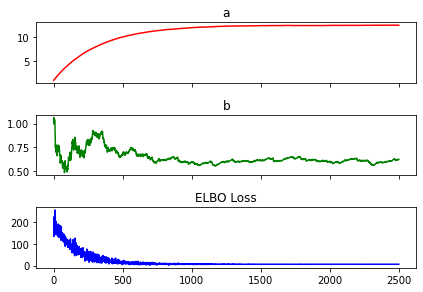

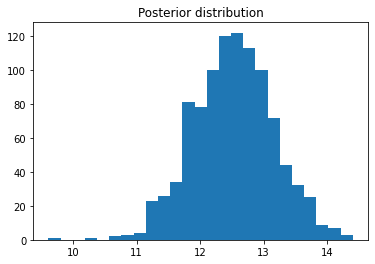

In [120]:
samples_q = [guide().item() for _ in range(1000)]
fig, axs = plt.subplots(3)
fig.tight_layout()
axs[0].plot(range(2500), a, 'r')
axs[0].set_title('a')
axs[1].plot(range(2500), b, 'g')
axs[1].set_title('b')
axs[2].plot(range(2500), losses, 'b')
axs[2].set_title('ELBO Loss')
for ax in fig.get_axes():
    ax.label_outer()
plt.show()
plt.hist(samples_q, bins=25)
plt.title('Posterior distribution')
plt.show()

### Task 4
* Much smoother distribution than the one before
* a is much closer to the true analytic values also

Note that both SVI and HMC estimate posterior distributions which closely match the analytical solution. This is expected for SVI as Q is drawn from the same function family as the analytical posterior.

# Next steps

There is so much more that is possible with Pyro; if you truly want to explore the power of Pyro, we highly recommend browsing through the official Pyro tutorials here: https://pyro.ai/examples/index.html#

There are examples of using Pyro for deep generative models, MLE and MAP estimation, time series modelling, Gaussian processes, ...

We also recommend reading `minipyro`, a stripped down version of Pyro which will help you understand its internals: https://pyro.ai/examples/minipyro.html


## A note on using GPUs
Combining stochastic gradient descent with PyTorch’s GPU-accelerated tensor math and automatic differentiation allows Pyro to scale variational inference to very high-dimensional parameter spaces and massive datasets.

Although not covered here, using CUDA in Pyro is very similar to using CUDA in standard PyTorch code: you just need to make sure all tensors (and any neural network models) are converted to CUDA types, see here for an example: https://github.com/pyro-ppl/pyro/blob/dev/examples/vae/vae.py